In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.interpolate import barycentric_interpolate 
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from scipy.optimize import root
rc('animation', html='html5')

In [4]:
class EulerLagrange(object):
    def __init__(self, x_range, L, N=1000):
        self.a, self.b = x_range
        self.N = N
        self.L = L
    
    def eval_J(self, y):
        """For this function you need only give a path y -- and I'll describe the length of time required
        to travers said path"""
        x_space = np.linspace(self.a, self.b, self.N)
        y_space = np.vectorize(y)(x_space)
        dy_space = np.zeros(y_space.shape)
        dy_space[0:-1] = np.diff(y_space)/np.diff(x_space)
        dy_space[-1] = (y_space[-1] - y_space[-2])/(x_space[-1] - x_space[-2])
        def y(x):
            itemindex = np.where(x_space==x)
            return y_space[itemindex]
        def y_prime(x):
            itemindex = np.where(x_space==x)
            return dy_space[itemindex]
        L = lambda x: self.L(x, y, y_prime)
        return np.trapz(L(x_space), x_space)

## Crossing the river without resisting the current
Somewhat intuitively one route to take would be keeping the boat pointed directly across the river -- we'd expect it to take two units of time to travel this distances 

The "shape" of this route would just be described as the integral of the current.

In [5]:
c = lambda x: (-7./10)*(x**2 - 1)
alpha = lambda x: (1 - c(x)**2)**(-1/2)

L = lambda x, y, y_prime: alpha(x)*(1 + (alpha(x)**2)*(y_prime(x)**2))**(1/2) - (alpha(x)**2)*(c(x))*(y_prime(x))

EulerLagrange((-1, 1), L).eval_J(lambda x: (-7/30)*x**3 + (7/10)*x)


2.000000654641907

## Solving generally

In [6]:
class pseudospectral_method(object):
    def _cheb(self, N):
        x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
        x.shape = (N+1, 1)
        lin = np.linspace(0,N,N+1)
        lin.shape = (N+1,1)
        c = np.ones((N+1,1))
        c[0], c[-1] = 2., 2.
        c = c*(-1.)**lin
        X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
        dX = X - X.T
        D = (c*(1./c).T)/(dX + np.eye(N+1))
        D = D - np.diag(np.sum(D.T,axis=0))
        x.shape = (N+1,)
        # Here we return the differentiation matrix and the Chebyshev points,
        # numbered fro
        return D, x
    def __init__(self, N=8, a=0, b=0, x_1=-1, x_2=1, el=None, fixed=True):
        self.N = N
        self.D, self.x = self._cheb(N)
        self.D2 = np.dot(self.D, self.D)
        self.oper = el(self.D, self.x)
        def oper_fixed(U):
            oper = self.oper(U)
            if a is not None:
                oper[-1] = U[-1]-a
            if b is not None:
                oper[0] = U[0]-b
            return oper
        guess = np.zeros(N+1)
        oper_to_opt = oper_fixed if fixed else self.oper
        self.solution = root(oper_to_opt, guess).x
        self.smooth_solution = barycentric_interpolate(self.x, self.solution, np.linspace(x_1,x_2,1000))
    def plot(self, plot_actual=False, actaul_sol=None):
        plt.figure(figsize=(20,10))
        if plot_actual:
             plt.plot(np.linspace(-1,1,100), actaul_sol(np.linspace(-1,1,100)), label="Actual")
        plt.plot(np.linspace(-1,1,1000), self.smooth_solution, label="N = {}".format(self.N))
        plt.legend(loc="best")

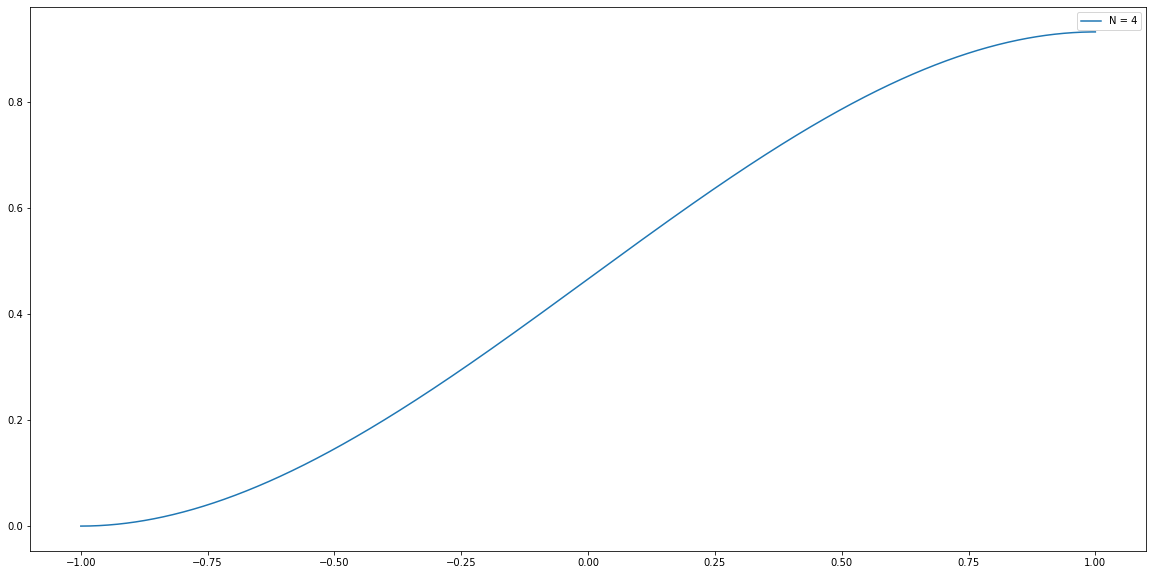

In [7]:
fastest_cross = pseudospectral_method(N=4, a=0, b=None, el=lambda D, X: lambda U: np.dot(D, alpha(X)**3*np.dot(D,U)*(1./np.sqrt((1+alpha(X)**2*np.dot(D,U)**2)))-alpha(X)**2*c(X)), fixed=True)
fastest_cross.plot()

## Boundry Condition
So we can cross the river in minimal time -- what about when we want to go down or up river some amount?

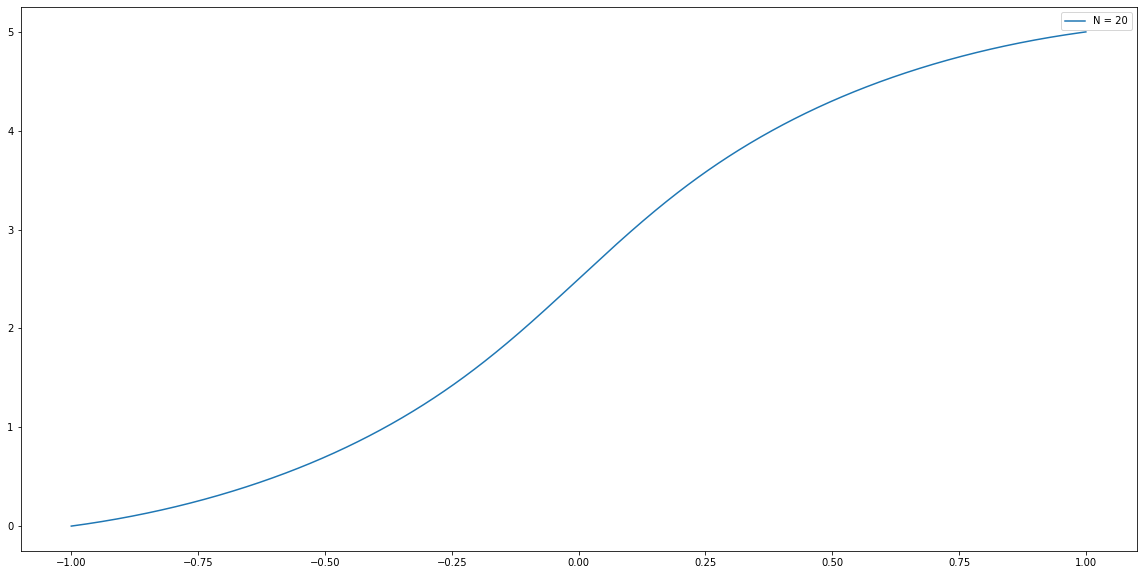

In [8]:
fastest_cross_with_boundry_condition = pseudospectral_method(N=20, a=0, b=5, el=lambda D, X: lambda U: np.dot(D, alpha(X)**3*np.dot(D,U)*(1./np.sqrt((1+alpha(X)**2*np.dot(D,U)**2)))-alpha(X)**2*c(X)), fixed=True)
fastest_cross_with_boundry_condition.plot()

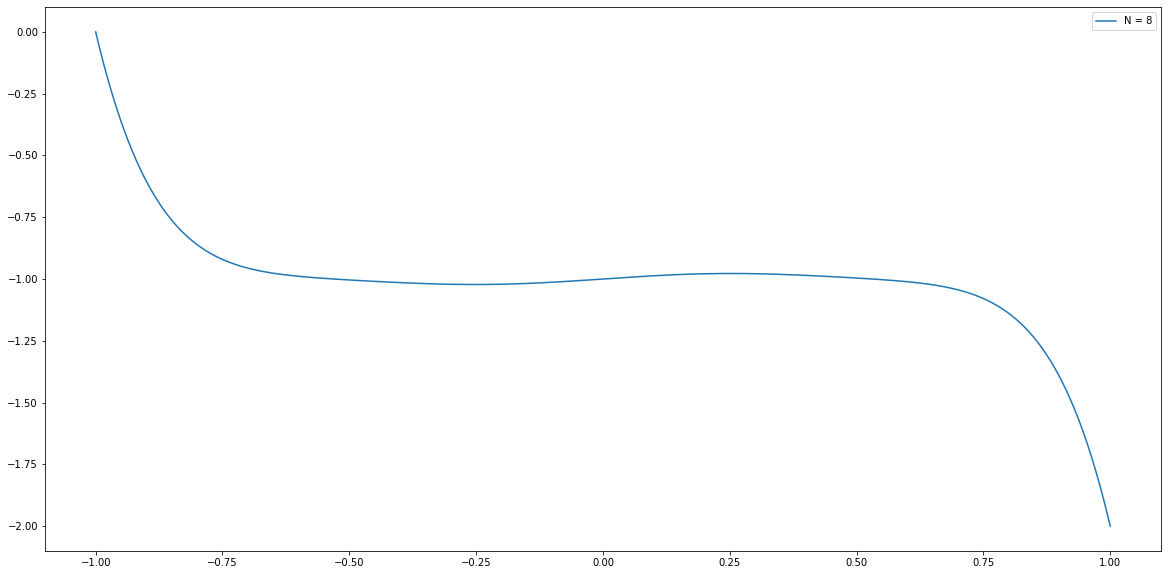

In [9]:
fastest_cross_with_boundry_condition = pseudospectral_method(N=8, a=0, b=-2, el=lambda D, X: lambda U: np.dot(D, alpha(X)**3*np.dot(D,U)*(1./np.sqrt((1+alpha(X)**2*np.dot(D,U)**2)))-alpha(X)**2*c(X)), fixed=True)
fastest_cross_with_boundry_condition.plot()

## Animating a route

In [14]:
lagrange_obj = EulerLagrange((-1, 1), L)

class RiverCrossing(object):
    """Class to handle modeling strategies crossing a river"""
    def __init__(self, river_current_func=lambda x: (-7./10)*(x**2 - 1), x_boundries=(-1, 1), y_boundries=(-1, 5), strat=lambda x: 0, path=lambda x: (-7/30)*x**3 + (7/10)*x):
        """river_current_func -- Function to model the current flow of the river
           x_boundries -- Bounds of the river to be crossed
           strat -- a function in time that returns the angle which the boat should be pointed"""
        self.river_current = river_current_func
        self.x_boundries = x_boundries
        self.y_boundries = y_boundries
        self.strategy = strat
        self.total_time = lagrange_obj.eval_J(path)
    def animate(self):
        """"""
        y_bound_diff = self.y_boundries[1] - self.y_boundries[0]
        x_generator = lambda t, x: np.cos(self.strategy(x))*1
        y_generator = lambda t, x: np.sin(self.strategy(x))*1 + self.river_current(x)
        fig = plt.figure(figsize=(12, 8*(y_bound_diff/6)), dpi= 80, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111, xlim=self.x_boundries, ylim=self.y_boundries)
        line, = plt.plot([], [], 'o-', lw=2) 
        time_text = ax.text(0.02, 0.92 + (6/y_bound_diff)/200, '', transform=ax.transAxes)
        total_time_text = ax.text(0.02, 0.87 - + (6/y_bound_diff)/200, 'TOTAL TIME = %.2f' % self.total_time, transform=ax.transAxes)
        self.X = [-1]
        self.Y = [0]
        interval = 0.05
        T_intervals = int(self.total_time // interval)
        total_time = None
        def animate(i):
            nonlocal total_time
            if self.X[-1]<self.x_boundries[1]:
                self.Y.append(self.Y[-1] + interval*y_generator(i*interval, self.X[-1]))
                self.X.append(self.X[-1] + interval*x_generator(i*interval, self.X[-1]))
            line.set_data(self.X, self.Y)
            time_text.set_text('time = %.2f' % (i*interval))
            return line, time_text
        anim = animation.FuncAnimation(fig, animate, frames=T_intervals, interval=interval*1000, blit=True)
        plt.close(anim._fig)
        return anim
    
def generate_strategy(pseudospect_obj):
    c = lambda x: (-7./10)*(x**2 - 1)
    def alpha(x):
        return 1./np.sqrt((1-c(x)**2))
    degree_pseudospect_obj = pseudospectral_method(N=pseudospect_obj.N, a=None, b=None, el=lambda D, X: lambda U: np.dot(D,pseudospect_obj.solution) - c(X)/np.cos(U)-np.tan(U), fixed=True)
    def optimum_strat(x):
        idx = np.abs(np.linspace(-1,1,len(degree_pseudospect_obj.smooth_solution)) - x).argmin()
        return degree_pseudospect_obj.smooth_solution[idx]
    def optimum_path(x):
        idx = np.abs(np.linspace(-1,1,len(pseudospect_obj.smooth_solution)) - x).argmin()
        return pseudospect_obj.smooth_solution[idx]
    return optimum_strat, optimum_path


In [15]:
fastest_cross = pseudospectral_method(N=4, a=0, b=None, el=lambda D, X: lambda U: np.dot(D, alpha(X)**3*np.dot(D,U)*(1./np.sqrt((1+alpha(X)**2*np.dot(D,U)**2)))-alpha(X)**2*c(X)), fixed=True)
optimum_strat, optimum_path = generate_strategy(fastest_cross)
RiverCrossing(strat=optimum_strat, path=optimum_path, y_boundries=(-1,2)).animate()

In [16]:
fastest_cross_with_boundry_condition = pseudospectral_method(N=20, a=0, b=5, el=lambda D, X: lambda U: np.dot(D, alpha(X)**3*np.dot(D,U)*(1./np.sqrt((1+alpha(X)**2*np.dot(D,U)**2)))-alpha(X)**2*c(X)), fixed=True)
optimum_strat, optimum_path = generate_strategy(fastest_cross_with_boundry_condition)
RiverCrossing(strat=optimum_strat, path=optimum_path, y_boundries=(-1,6)).animate()

In [17]:
fastest_cross_with_boundry_condition = pseudospectral_method(N=8, a=0, b=-2, el=lambda D, X: lambda U: np.dot(D, alpha(X)**3*np.dot(D,U)*(1./np.sqrt((1+alpha(X)**2*np.dot(D,U)**2)))-alpha(X)**2*c(X)), fixed=True)
optimum_strat, optimum_path = generate_strategy(fastest_cross_with_boundry_condition)
RiverCrossing(strat=optimum_strat, path=optimum_path, y_boundries=(-3,1)).animate()